## Comparison of 201905 Model Phytoplankton to HPLC Phytoplankton Abundances from Nina Nemcek

In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

Note: crypto+hapto+prasino grouping was actually determined based on comparisons to 201812 model run

## Load data and matched model output

In [2]:
modSourceDir= '/results2/SalishSea/nowcast-green.202111/'
modver='202111'
Chl_N=1.8 # Chl:N ratio
startYMD=(2015,1,1)
endYMD=(2018,12,31)

In [3]:
start_date = dt.datetime(startYMD[0],startYMD[1],startYMD[2])
end_date = dt.datetime(endYMD[0],endYMD[1],endYMD[2]) #dt.datetime(2019,6,30)

In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/mesh_mask202108.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [6]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [7]:
if os.path.isfile('matched_'+modver+datestr+'_NewALLO.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'_NewALLO.pkl', 'rb' ) )
    print('matched_'+modver+datestr+'_NewALLO.pkl')
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017_NewALLO.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018_NewALLO.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    #df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    #df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    #df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    #df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'].values,df['Lat'].values),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'].values,df['Lat'].values),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'].values,df['p'].values,df['Lon'].values,df['Lat'].values)
    df['CT']=gsw.CT_from_t(df['SA'].values,df['Temperature'].values,df['p'].values)
    df.rename({'TchlA':'TchlA (ug/L)','Raphido':'Raphidophytes','Dinoflagellates-1':'Dinoflagellates',
            'Dictyo':'Dictyochophytes'},axis=1, inplace=True, errors='raise')
    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'biol_T','silicon':'biol_T','ammonium':'biol_T','diatoms':'biol_T','flagellates':'biol_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'biol_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'_NewALLO.pkl','wb') as f:
        pickle.dump(data,f)

matched_202111_20150101_20181231_NewALLO.pkl


In [8]:
data.keys()

Index(['FIL:START TIME YYYY/MM/DD HH:MM:SS', 'LOC:STATION', 'Lat', 'Lon',
       'LOC:WATER DEPTH', 'Sample_Number', 'Temperature', 'Salinity',
       'Oxygen:Dissolved:CTD', 'pH:SBE:Nominal', 'Salinity:Bottle',
       'Flag:Salinity:Bottle', 'Flag:Chlorophyll:Extracted',
       'Flag:Nitrate_plus_Nitrite', 'Flag:Silicate', 'Flag:Phosphate',
       'Cruise', 'Oxygen:Dissolved', 'Flag:Oxygen:Dissolved', 'Diatoms-1',
       'Diatoms-2', 'Prasinophytes', 'Cryptophytes', 'Dinoflagellates',
       'Haptophytes', 'Dictyochophytes', 'Raphidophytes', 'Cyanobacteria',
       'TchlA (ug/L)', 'Pressure [decibar]', 'Transmissivity [*/metre]',
       'PAR [uE/m^2/sec]', 'PAR:Reference [uE/m^2/sec]',
       'Oxygen:Dissolved:SBE [mL/L]', 'Oxygen:Dissolved:SBE [umol/kg]',
       'Chlorophyll:Extracted [mg/m^3]', 'Phaeo-Pigment:Extracted [mg/m^3]',
       'Nitrate_plus_Nitrite [umol/L]', 'Silicate [umol/L]',
       'Phosphate [umol/L]', 'Bottle_Number', 'Oxygen:Dissolved [mL/L]',
       'Oxygen:Dissol

In [9]:
data['LOC:STATION'].unique()

array(['SI', '59', '102', '75', '72', '69', 'ADCP', '65', '63', '62',
       '56', '46', '42', '39', 'GE01', '27', '2', '3', 'BS', '6', '9',
       '12', '14', '16', '22', '11', 'CPF2', 'CPF1', '24', '28', '38',
       '41', 'BS17', '19', 'GEO1', 'BS11', 'SC-04', '66', 'BI2', 'JF2',
       'HARO59', 'SI03', '15', 'SC04', '40', 'qu39', 'Van1', 'BS-11',
       'adcp', 'QU39', 'CPF-2', 'CPF-1', 'Haro 59', 'BS2', 'IS-2', 'PEN1',
       'PEN2', 'PEN3'], dtype=object)

In [10]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

In [11]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

In [12]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

## Determine which HPLC groups have the highest biomass

In [13]:
data['Diatoms-1'].mean() ## Highest biomass

2.1757399193548412

In [14]:
data['Diatoms-2'].mean() ## include

0.3043850806451614

In [15]:
data['Cyanobacteria'].mean() ## exclude due to low biomass

0.03817540322580645

In [16]:
data['Cryptophytes'].mean() ## include

0.4574556451612899

In [17]:
data['Prasinophytes'].mean() ## include

0.21607862903225808

In [18]:
data['Haptophytes'].mean() ## include

0.23795766129032253

In [19]:
data['Dictyochophytes'].mean() ## exclude due to low biomass

0.039802419354838664

In [20]:
data['Dinoflagellates'].mean() # exclude due to low biomass

0.10347580645161288

In [21]:
data['Raphidophytes'].mean() ## Include

0.40433064516129036

In [22]:
data['Month']=[ii.month for ii in data['dtUTC']]

In [23]:
monthlymean=data.groupby(['Month']).mean()

In [24]:
monthlymean['Diatoms-1']

Month
2     0.120424
3     3.233714
4     4.943088
5     2.529966
6     2.168265
7     0.551176
8     2.249000
9     0.941815
10    1.593719
11    0.785317
Name: Diatoms-1, dtype: float64

In [25]:
monthlymean['HPLCDiatoms']=(monthlymean['Diatoms-1']+monthlymean['Raphidophytes']+monthlymean['Diatoms-2'])

In [26]:
monthlymean['HPLCFlag']=(monthlymean['Cryptophytes']+monthlymean['Haptophytes']+monthlymean['Raphidophytes'])

In [27]:
monthlymean['HPLCDiatoms']

Month
2     0.337182
3     3.697286
4     5.422284
5     3.205103
6     3.780675
7     0.780706
8     4.946000
9     1.361207
10    2.194649
11    0.897024
Name: HPLCDiatoms, dtype: float64

In [28]:
monthlysem=logt(data.groupby(['Month']).sem())

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/groupby/groupby.py:1510: RuntimeWarning: divide by zero encountered in true_divide
  result.iloc[:, cols].values / np.sqrt(self.count().iloc[:, cols]).values


In [29]:
monthlymean['L10mod_diatoms']=logt(monthlymean['mod_diatoms']*Chl_N)
monthlymean['L10mod_flagellates']=logt(monthlymean['mod_flagellates']*Chl_N)
monthlymean['L10Diatoms-1']=logt(monthlymean['Diatoms-1'])
monthlymean['L10Diatoms-2']=logt(monthlymean['Diatoms-2'])
monthlymean['L10Cryptophytes']=logt(monthlymean['Cryptophytes'])
monthlymean['L10Prasinophytes']=logt(monthlymean['Prasinophytes'])
monthlymean['L10Haptophytes']=logt(monthlymean['Haptophytes'])
monthlymean['L10Raphidophytes']=logt(monthlymean['Raphidophytes'])
monthlymean['L10TotalChla']=logt(monthlymean['TchlA (ug/L)'])

monthlymean['L10HPLCDiatoms']=logt(monthlymean['HPLCDiatoms'])
monthlymean['L10HPLCFlag']=logt(monthlymean['HPLCFlag'])

In [30]:
monthlymean['L10mod_diatoms']

Month
2    -0.454133
3    -0.111755
4     0.048108
5     0.132362
6    -0.304687
7    -0.464635
8    -0.420963
9    -0.495028
10   -0.465176
11   -0.659019
Name: L10mod_diatoms, dtype: float64

In [31]:
# define inverse log transform with same shift
def logt_inv(y):
    return 10**y-.001

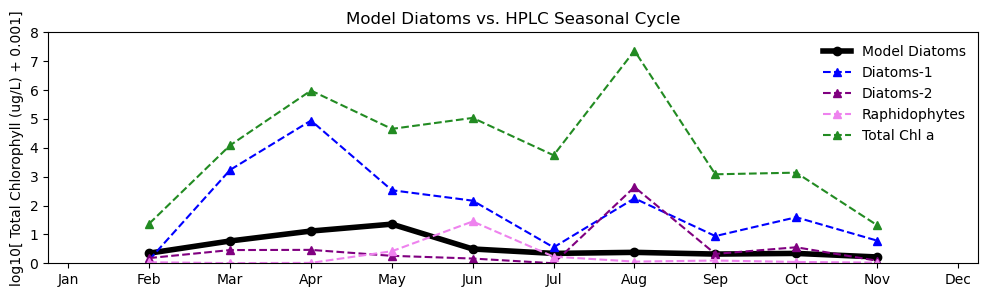

In [32]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_diatoms'])),
              fmt='k-o',capsize=5,color='blue',label='Model Diatoms',linewidth=4) 

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10Diatoms-1'])),
            fmt='--^',capsize=5,color='blue',label='Diatoms-1')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10Diatoms-2'])),
            fmt='--^',capsize=5,color='purple',label='Diatoms-2')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10Raphidophytes'])),
            fmt='--^',capsize=5,color='violet',label='Raphidophytes')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10TotalChla'])),
            fmt='--^',capsize=5,color='forestgreen',label='Total Chl a')

      
            
ax.set_ylim(0,8)
ax.set_xlim(0.75,12.25)
ax.set_title('Model Diatoms vs. HPLC Seasonal Cycle')
ax.set_ylabel('log10[ Total Chlorophyll (ug/L) + 0.001]',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.0))
#fig.savefig('SoGMesozoopSeasonalCycle.png',bbox_inches='tight')

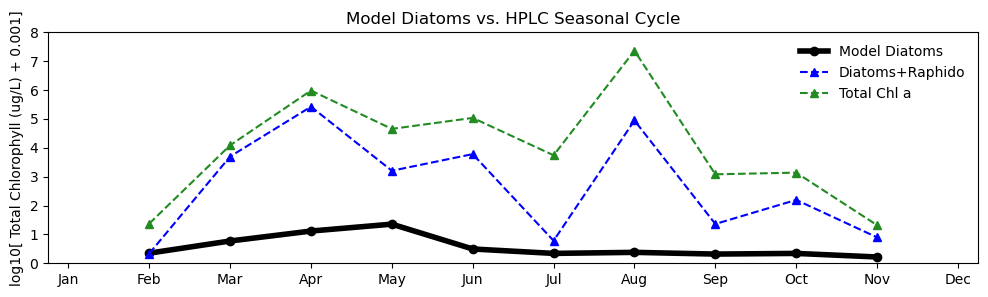

In [33]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_diatoms'])),
              fmt='k-o',capsize=5,color='blue',label='Model Diatoms',linewidth=4) 

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10HPLCDiatoms'])),
            fmt='--^',capsize=5,color='blue',label='Diatoms+Raphido')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10TotalChla'])),
            fmt='--^',capsize=5,color='forestgreen',label='Total Chl a')

      
            
ax.set_ylim(0,8)
ax.set_xlim(0.75,12.25)
ax.set_title('Model Diatoms vs. HPLC Seasonal Cycle')
ax.set_ylabel('log10[ Total Chlorophyll (ug/L) + 0.001]',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.0))
#fig.savefig('SoGMesozoopSeasonalCycle.png',bbox_inches='tight')

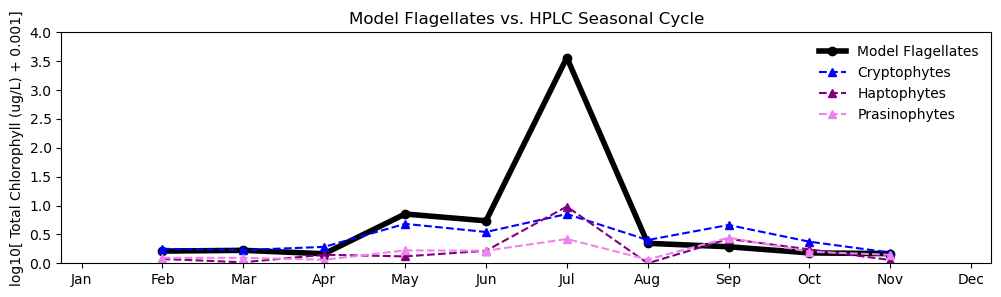

In [34]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_flagellates'])),
              fmt='k-o',capsize=5,color='blue',label='Model Flagellates',linewidth=4) 

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10Cryptophytes'])),
            fmt='--^',capsize=5,color='blue',label='Cryptophytes')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10Haptophytes'])),
            fmt='--^',capsize=5,color='purple',label='Haptophytes')

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10Prasinophytes'])),
            fmt='--^',capsize=5,color='violet',label='Prasinophytes')

      
            
ax.set_ylim(0,4)
ax.set_xlim(0.75,12.25)
ax.set_title('Model Flagellates vs. HPLC Seasonal Cycle')
ax.set_ylabel('log10[ Total Chlorophyll (ug/L) + 0.001]',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.0))
#fig.savefig('SoGMesozoopSeasonalCycle.png',bbox_inches='tight')

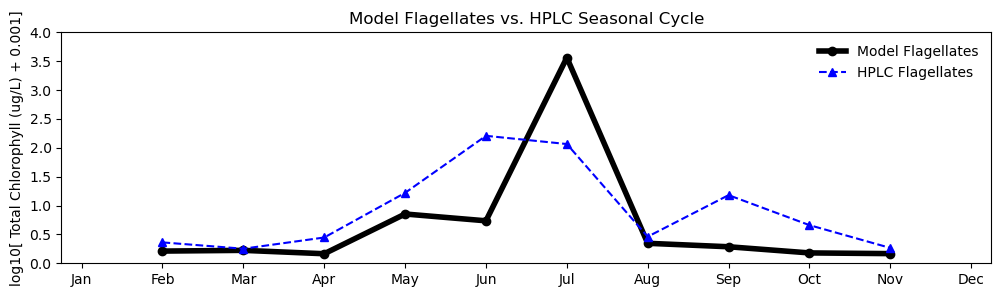

In [35]:
fig,ax=plt.subplots(1,1,figsize=(12,3))
ax.set_xticks(np.arange(1,13,1))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']) #where you replace axs[0] with whatever your axis is named

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10mod_flagellates'])),
              fmt='k-o',capsize=5,color='blue',label='Model Flagellates',linewidth=4) 

ax.errorbar(monthlymean.index,(logt_inv(monthlymean['L10HPLCFlag'])),
            fmt='--^',capsize=5,color='blue',label='HPLC Flagellates')
      
            
ax.set_ylim(0,4)
ax.set_xlim(0.75,12.25)
ax.set_title('Model Flagellates vs. HPLC Seasonal Cycle')
ax.set_ylabel('log10[ Total Chlorophyll (ug/L) + 0.001]',fontsize=10)
ax.legend(fontsize=10,frameon=False,bbox_to_anchor=(1., 1.0))
#fig.savefig('SoGMesozoopSeasonalCycle.png',bbox_inches='tight')

### What do HPLC-based observations look like in terms of species composition?

In [36]:
hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')

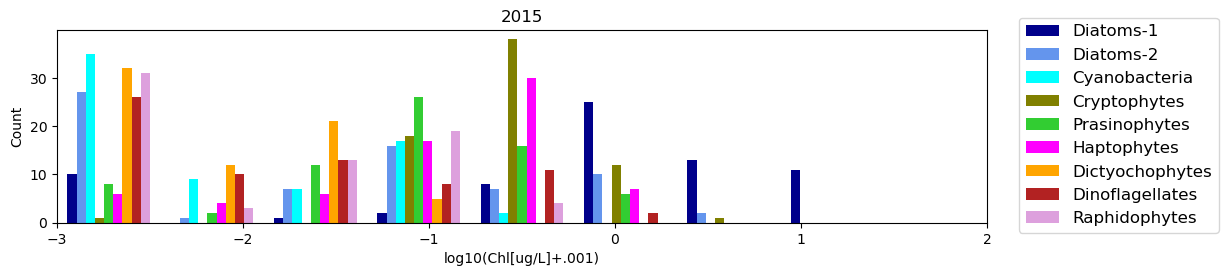

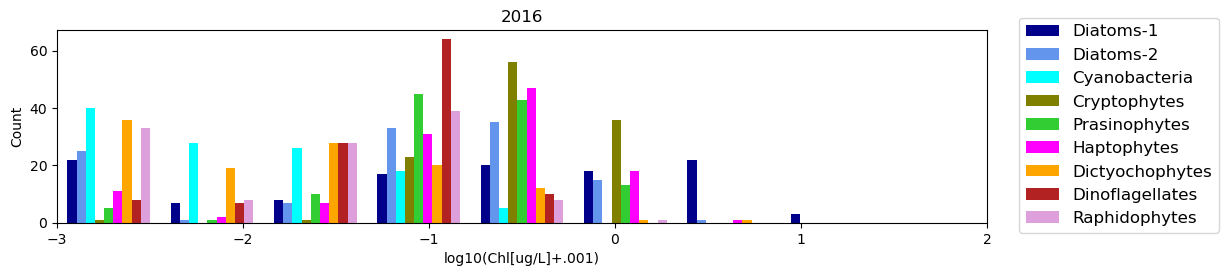

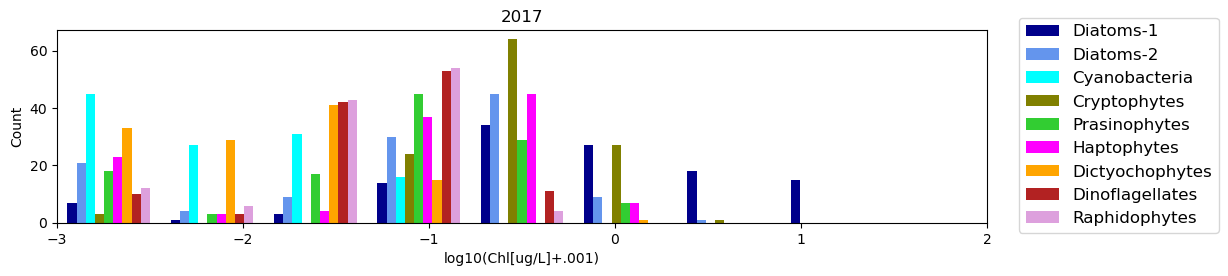

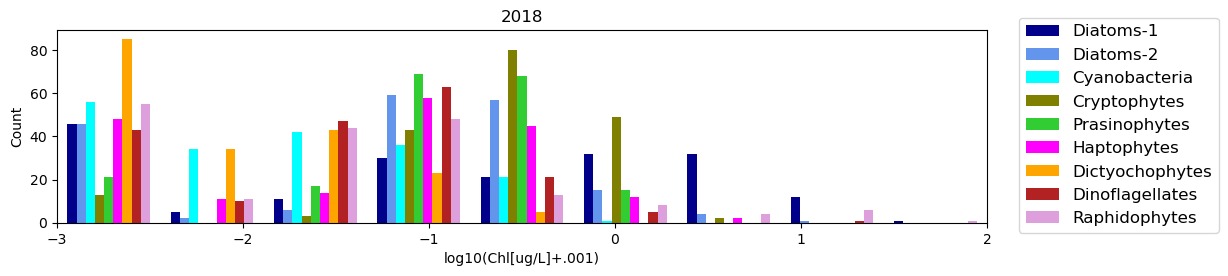

In [37]:
### Histogram by Year:
for year in range(2015,2019):
    fig,ax=plt.subplots(1,1,figsize=(12,2.5))
    hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
    x=np.array([logt(data[data.Year==year][el]) for el in hplclist]).T
    cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')
    bins=np.linspace(-3,2,10)
    ax.hist(x, bins, density=False, histtype='bar', color=cols, label=hplclist);
    fig.legend(prop={'size': 12},loc='center right',bbox_to_anchor=[1.1,.5,0,0]);
    ax.set_xlim(-3,2)
    ax.set_xlabel('log10(Chl[ug/L]+.001)')
    ax.set_ylabel('Count')
    ax.set_title(year)

- The most abundant groups are diatoms-1
- Medium abundance groups includ cryptophytes, prasinophytes, haptophytes, and raphidophytes, and dinoflagellates
- Low abundance groups include cyanobacteria and dictyochophytes
- The dinoflagellate contribution was higher in 2016-2018 compared to 2015.

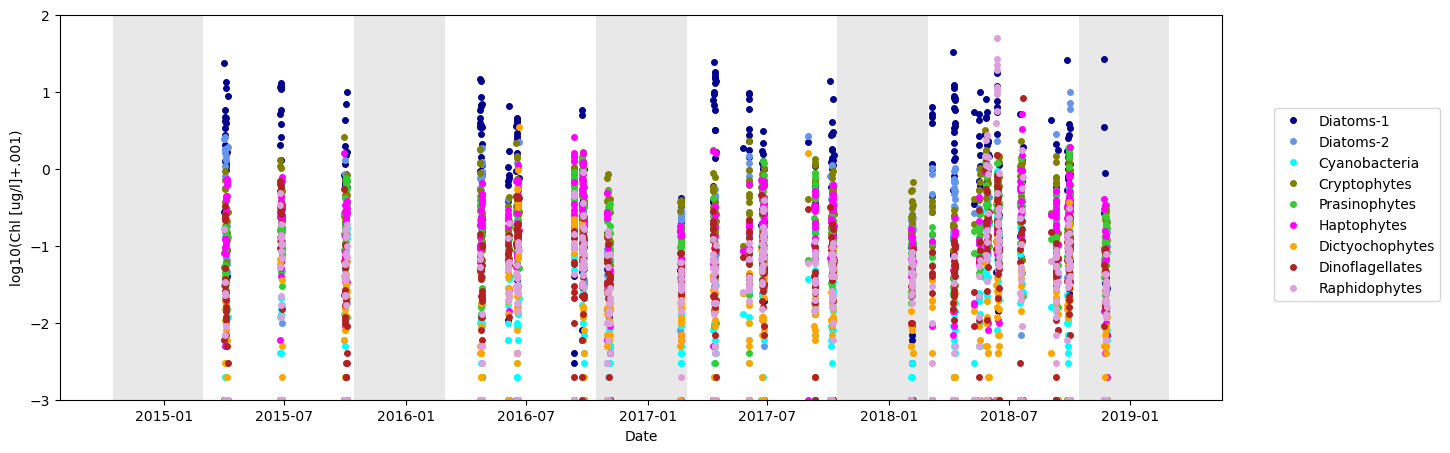

In [38]:
x=np.array([logt(data[el]) for el in hplclist]).T
fig,ax=plt.subplots(1,1,figsize=(15,5))
for i in range(0,len(hplclist)):
    ax.plot(data['dtUTC'],x[:,i],'o',color=cols[i],label=hplclist[i],ms=4)
fig.legend(loc='center right',bbox_to_anchor=[1.05,.5])
ax.set_ylim(-3,2)
ax.set_xlabel('Date')
ax.set_ylabel('log10(Chl [ug/l]+.001)')
for i in range(2015,2020):
    ax.axvspan(dt.datetime(i-1,10,15),dt.datetime(i,3,1), facecolor='lightgrey', alpha=0.5)

- Diatoms-1 peak during the spring bloom, but are high most of thte time.
- Diatoms-2 are lower abundance than diatoms-1 and show a less consistent seasonal pattern; they bloomed in spring 2015 and fall 2018
- Cryptophytes make up a consistent medium-level contribution
- Raphidophytes bloomed in summer 2018 in many samples
- Dictyochophytes exhibit occasional isolated high values but are often low abundance
- Dinoflagellates also exhibit occasional bloom values and generally low-to-medium abundance

## Model vs Obs Plots for various model-obs groups

- HPLC agreement for 201905 diatoms is not as strong as for 201805, but non-diatom agreement might be slightly better. 
- There is a separation between low and high model values for non-diatoms that is not present in 201812 comparisons

### By time of year

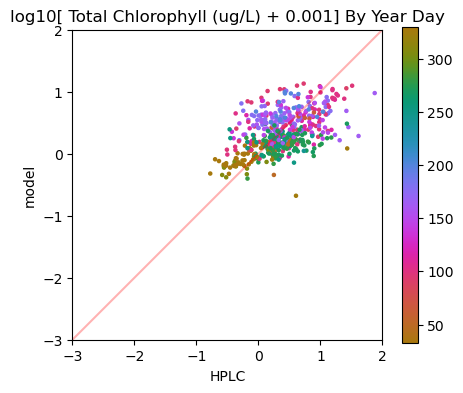

In [39]:
fig,ax=plt.subplots(1,1,figsize=(5,4.1))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_diatoms'])),
          c=data['yd'],s=5,cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-3,2)
ax.set_ylim(-3,2);
ax.set_aspect(1)
fig.colorbar(m)

- Winter chlorophyll agrees with HPLC
- Spring bloom chlorophyll can be too low or too high; this likely reflects poor spring bloom timing
- Summer chlorophyll tends high
- fall chlorophyll tends low

### Correlation Coefficient Matrix

In [40]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
#data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']
data['CPH']=data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_TChl']]

In [41]:
dfVars.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_TChl
Diatoms-1,1.000000,0.129174,-0.044520,-0.104293,-0.155529,-0.089528,-0.038014,0.068507,0.186019,0.986013,-0.143394,0.799078,0.552591,-0.087597,0.467123
Diatoms-2,0.129174,1.000000,0.087055,0.065789,0.041872,0.045439,0.204256,0.030159,0.089479,0.292639,0.067138,0.278908,0.071459,-0.136831,-0.015512
Cyanobacteria,-0.044520,0.087055,1.000000,0.455047,0.673585,0.265069,0.134517,0.111427,0.471045,-0.028299,0.565312,0.323326,-0.080177,0.236285,0.067468
Cryptophytes,-0.104293,0.065789,0.455047,1.000000,0.629727,0.330846,0.059123,0.105006,0.151756,-0.089512,0.850031,0.145622,-0.050763,0.236992,0.095581
Prasinophytes,-0.155529,0.041872,0.673585,0.629727,1.000000,0.273744,0.115485,0.043839,0.193154,-0.142939,0.760689,0.115373,-0.167797,0.197561,-0.038427
Haptophytes,-0.089528,0.045439,0.265069,0.330846,0.273744,1.000000,0.028364,-0.005455,-0.014300,-0.078695,0.718854,0.040637,-0.043761,0.239936,0.103952
Dictyochophytes,-0.038014,0.204256,0.134517,0.059123,0.115485,0.028364,1.000000,0.070478,0.073749,-0.002326,0.079637,0.084752,-0.061005,0.041135,-0.032536
Dinoflagellates,0.068507,0.030159,0.111427,0.105006,0.043839,-0.005455,0.070478,1.000000,0.224567,0.071130,0.063264,0.247006,0.002458,0.121665,0.075910
Raphidophytes,0.186019,0.089479,0.471045,0.151756,0.193154,-0.014300,0.073749,0.224567,1.000000,0.194417,0.130332,0.697246,0.124238,-0.027743,0.100154
DD,0.986013,0.292639,-0.028299,-0.089512,-0.142939,-0.078695,-0.002326,0.071130,0.194417,1.000000,-0.126991,0.817431,0.544875,-0.107468,0.447841


##### Strongest correlations:
Model diatoms and:
- Total chla: 0.343112
- Diatoms-1: 0.329545
- Diatoms-1+Diatoms-2: 0.329332

Model flagellates and:
- crypto+hapto+prasino: 0.377130
- haptophytes: 0.309359
- prasinophytes: 0.288055
- cryptophytes: 0.283430
- cyanobacteria: 0.271249 (but remember that cyanobacteria abundances are low)

### Variance-Covariance Matrix

In [42]:
dfVars.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_TChl
Diatoms-1,17.030227,0.383433,-0.014114,-0.180451,-0.176579,-0.147258,-0.029133,0.111324,2.290018,17.413661,-0.504288,19.195920,5.121662,-0.521794,4.599868
Diatoms-2,0.383433,0.517381,0.004810,0.019841,0.008286,0.013027,0.027284,0.008542,0.191999,0.900814,0.041154,1.167819,0.115441,-0.142065,-0.026624
Cyanobacteria,-0.014114,0.004810,0.005901,0.014656,0.014236,0.008116,0.001919,0.003371,0.107947,-0.009303,0.037008,0.144586,-0.013833,0.026200,0.012367
Cryptophytes,-0.180451,0.019841,0.014656,0.175789,0.072638,0.055288,0.004603,0.017336,0.189807,-0.160610,0.303715,0.355411,-0.047801,0.143426,0.095625
Prasinophytes,-0.176579,0.008286,0.014236,0.072638,0.075690,0.030017,0.005900,0.004749,0.158524,-0.168293,0.178345,0.184770,-0.103681,0.078455,-0.025227
Haptophytes,-0.147258,0.013027,0.008116,0.055288,0.030017,0.158861,0.002099,-0.000856,-0.017002,-0.134231,0.244167,0.094285,-0.039174,0.138039,0.098865
Dictyochophytes,-0.029133,0.027284,0.001919,0.004603,0.005900,0.002099,0.034487,0.005154,0.040856,-0.001849,0.012603,0.091620,-0.025445,0.011027,-0.014418
Dinoflagellates,0.111324,0.008542,0.003371,0.017336,0.004749,-0.000856,0.005154,0.155056,0.263792,0.119866,0.021229,0.566188,0.002173,0.069152,0.071326
Raphidophytes,2.290018,0.191999,0.107947,0.189807,0.158524,-0.017002,0.040856,0.263792,8.899071,2.482017,0.331329,12.107873,0.832385,-0.119462,0.712923
DD,17.413661,0.900814,-0.009303,-0.160610,-0.168293,-0.134231,-0.001849,0.119866,2.482017,18.314475,-0.463135,20.363739,5.237103,-0.663859,4.573244


##### largest covariances:
Model diatoms and:
- TChlA: 4.185330
- Diatoms-1+Diatoms-2: 2.953355
- Diatoms-1: 2.849766
- Raphidophytes: 1.242441

Model flagellates and:
- crypto+hapto+prasino: 0.391340
- haptophytes: 0.150141
- cryptophytes: 0.144700

### Corr Coeff matrix with log transformed values:

In [43]:
dflog=pd.DataFrame()
for el in ['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','CPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_TChl']:
    dflog[el]=logt(data[el])
dflog.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_TChl
Diatoms-1,1.000000,0.158963,-0.183906,-0.200691,-0.330748,-0.178564,-0.022753,0.257098,-0.044532,-0.240631,0.620741,0.466016,-0.155016,0.297128
Diatoms-2,0.158963,1.000000,-0.070727,-0.017724,-0.081120,-0.206987,0.260879,0.110120,-0.069205,-0.095680,0.117311,0.176540,-0.417193,-0.232775
Cyanobacteria,-0.183906,-0.070727,1.000000,0.308677,0.391266,0.322685,0.341206,0.001006,0.323720,0.387215,0.114417,-0.343320,0.370117,0.020899
Cryptophytes,-0.200691,-0.017724,0.308677,1.000000,0.705089,0.328445,0.337350,0.256664,0.383761,0.872284,0.077971,-0.105129,0.287357,0.069604
Prasinophytes,-0.330748,-0.081120,0.391266,0.705089,1.000000,0.299601,0.401870,0.140807,0.462423,0.698793,-0.023818,-0.334655,0.356477,-0.116457
Haptophytes,-0.178564,-0.206987,0.322685,0.328445,0.299601,1.000000,0.204290,0.047297,0.189056,0.576696,0.063931,-0.148796,0.270823,0.063679
Dictyochophytes,-0.022753,0.260879,0.341206,0.337350,0.401870,0.204290,1.000000,0.267118,0.337107,0.328808,0.131390,-0.121694,0.016128,-0.116952
Dinoflagellates,0.257098,0.110120,0.001006,0.256664,0.140807,0.047297,0.267118,1.000000,0.354625,0.246911,0.416244,0.116046,0.142453,0.148124
Raphidophytes,-0.044532,-0.069205,0.323720,0.383761,0.462423,0.189056,0.337107,0.354625,1.000000,0.370869,0.227029,-0.134295,0.247752,-0.003059
CPH,-0.240631,-0.095680,0.387215,0.872284,0.698793,0.576696,0.328808,0.246911,0.370869,1.000000,0.125576,-0.149561,0.336887,0.077857


### Cov matrix with log transformed values:

In [44]:

dflog.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_TChl
Diatoms-1,1.707049,0.223426,-0.191222,-0.156507,-0.337293,-0.224417,-0.022976,0.263191,-0.054699,-0.169667,0.364806,0.341471,-0.085287,0.125425
Diatoms-2,0.223426,1.157251,-0.060550,-0.011380,-0.068113,-0.214188,0.216906,0.092818,-0.069990,-0.055547,0.056765,0.106509,-0.188989,-0.080904
Cyanobacteria,-0.191222,-0.060550,0.633347,0.146625,0.243042,0.247024,0.209872,0.000628,0.242199,0.166302,0.040958,-0.153232,0.124035,0.005373
Cryptophytes,-0.156507,-0.011380,0.146625,0.356259,0.328485,0.188575,0.155626,0.120032,0.215341,0.280974,0.020934,-0.035191,0.072225,0.013423
Prasinophytes,-0.337293,-0.068113,0.243042,0.328485,0.609223,0.224942,0.242433,0.086112,0.339321,0.294348,-0.008362,-0.146492,0.117167,-0.029368
Haptophytes,-0.224417,-0.214188,0.247024,0.188575,0.224942,0.925289,0.151881,0.035647,0.170967,0.299372,0.027662,-0.080271,0.109701,0.019790
Dictyochophytes,-0.022976,0.216906,0.209872,0.155626,0.242433,0.151881,0.597360,0.161760,0.244945,0.137147,0.045678,-0.052749,0.005249,-0.029204
Dinoflagellates,0.263191,0.092818,0.000628,0.120032,0.086112,0.035647,0.161760,0.613904,0.261217,0.104403,0.146699,0.050993,0.047001,0.037497
Raphidophytes,-0.054699,-0.069990,0.242199,0.215341,0.339321,0.170967,0.244945,0.261217,0.883823,0.188160,0.096005,-0.070806,0.098081,-0.000929
CPH,-0.169667,-0.055547,0.166302,0.280974,0.294348,0.299372,0.137147,0.104403,0.188160,0.291239,0.030483,-0.045266,0.076559,0.013575


## Multiple Linear Regression: 

#### HPLC groups and model diatoms

In [45]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [46]:
m

array([ 0.16048094,  0.01051997, -0.64172951,  0.28233337, -0.59758976,
        0.06317976, -0.1975339 , -0.14851803,  0.0282783 ,  0.63097916])

In [47]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.16048093818832007
Diatoms-2 0.010519970094998887
Cyanobacteria -0.6417295056014041
Cryptophytes 0.28233337282272647
Prasinophytes -0.5975897577441455
Haptophytes 0.06317976130952391
Dictyochophytes -0.19753389767897286
Dinoflagellates -0.14851803482006598
Raphidophytes 0.028278297310813744
ones 0.6309791568299681


#### try again with a subset that showed some relationship (and diatoms-2):

In [48]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [49]:
clist=('Diatoms-1','Diatoms-2','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.16602317561354935
Diatoms-2 -0.0028340615459435115
Cryptophytes 0.009860554433723141
Raphidophytes 0.00909222817340724
ones 0.5935663018257754


In [50]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [51]:
clist=('Diatoms-1','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.16596081178508507
Cryptophytes 0.0095174595785123
Raphidophytes 0.009054448757959688
ones 0.5930115692984369


#### HPLC groups and model flagellates

In [52]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [53]:
m

array([-0.00286216, -0.1863464 ,  2.71388572,  0.26389668, -0.22944351,
        0.30249939,  0.17284537,  0.25077892, -0.04481139,  0.44345868])

In [54]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 -0.002862160229497781
Diatoms-2 -0.18634639748700466
Cyanobacteria 2.7138857246806354
Cryptophytes 0.26389667777964854
Prasinophytes -0.22944351319050468
Haptophytes 0.30249938610821747
Dictyochophytes 0.17284536961688818
Dinoflagellates 0.25077891818356124
Raphidophytes -0.04481139299190836
ones 0.44345867912549675


In [55]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             data.loc[ii]['Dinoflagellates'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [56]:
clist=('Diatoms-1','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 -0.012887495862557191
Cyanobacteria 1.56171427079357
Cryptophytes 0.23363182459426396
Prasinophytes -0.11828121620686405
Haptophytes 0.3328894193157056
Dictyochophytes 0.01846864288998981
Dinoflagellates 0.20179844491142504
ones 0.4282224804054473


#### look at Cryptophytes, Prasinophytes, and Haptophytes (+cyanobacteria), the groups that showed a relationship to flagellates in 201812

In [57]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [58]:
clist=('Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Cyanobacteria 1.626088474941196
Cryptophytes 0.2596831450055805
Prasinophytes -0.11419459973817783
Haptophytes 0.33017853926671836
Dictyochophytes 0.05191855674833157
ones 0.40511971993168866


Diatoms:
- Cryptophytes 
- Diatoms-1 
- Raphidophytes 

Flagellates:
- Cyanobacteria 
- Cryptophytes 
- Prasinophytes
- Haptophytes
- maybe dinoflagellates
- cyanobacteria make up small fraction of abundance; Nina says leave out

M. rubrum:
- Cyanobacteria

None:
- Diatoms-2
- Dictyochophytes
- Dinoflagellates?

##### Nina says Do not include cyanos in flagellate-like group: they are not flagellates and their abundance is low

### Individual phytoplankton groups compared to  model groups (1:1 correspondence not expected)

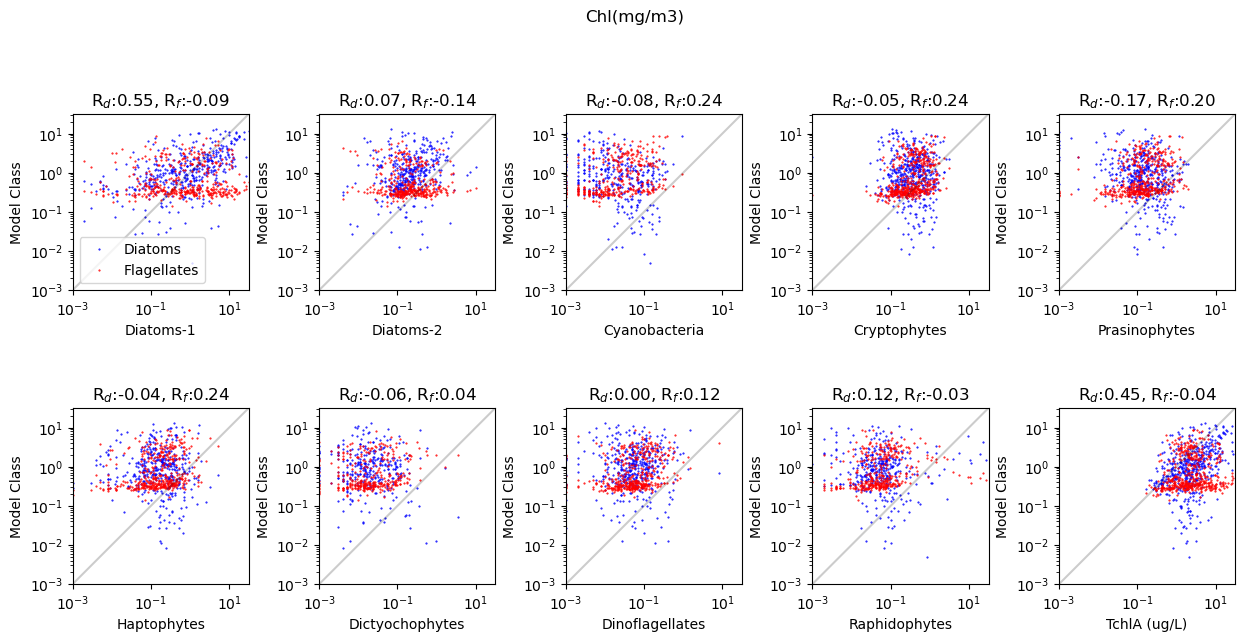

In [59]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','TchlA (ug/L)')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ix=~np.isnan(np.squeeze(data.loc[:,[chplc[ii]]].values))
    #ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',ms=1,color='blue',label='Diatoms')
    #ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',ms=1,color='red',label='Flagellates')
    ax[ii].plot(data.loc[:,[chplc[ii]]].values,mvar1,'.',ms=1,color='blue',label='Diatoms')
    ax[ii].plot(data.loc[:,[chplc[ii]]].values,mvar2,'.',ms=1,color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    r1,p1=spst.pearsonr(np.squeeze(data.loc[ix,[chplc[ii]]].values),mvar1[ix])
    r2,p2=spst.pearsonr(np.squeeze(data.loc[ix,[chplc[ii]]].values),mvar2[ix])
    ax[ii].set_title(f"R$_d$:{r1:.2f}, R$_f$:{r2:.2f}")
    ax[ii].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
    ax[ii].set_xlim((10**-3,10**1.5))
    ax[ii].set_ylim((10**-3,10**1.5))
    ax[ii].set_aspect(1)
    ax[ii].set_xscale('log')
    ax[ii].set_yscale('log')
ax[0].legend()
#fig.suptitle('log10[Chl(mg/m3)+.001]');
fig.suptitle('Chl(mg/m3)');

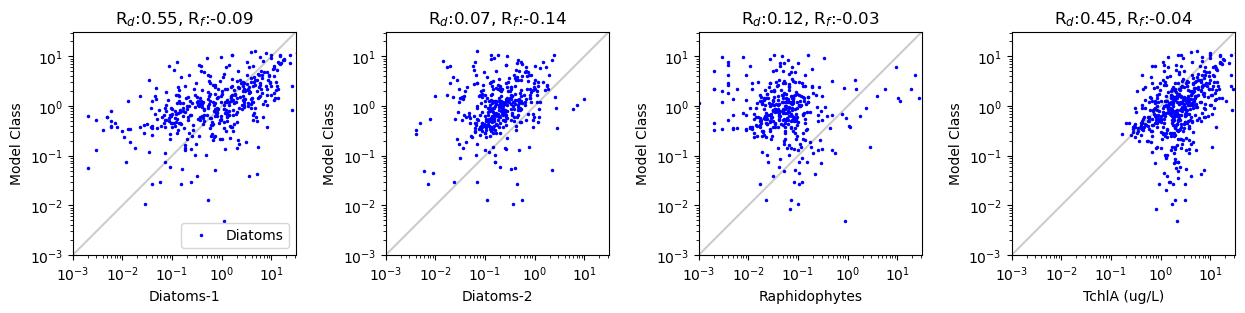

In [60]:
fig,ax=plt.subplots(1,4,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()


chplc=('Diatoms-1', 'Diatoms-2','Raphidophytes','TchlA (ug/L)')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ix=~np.isnan(np.squeeze(data.loc[:,[chplc[ii]]].values))
    #ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',ms=1,color='blue',label='Diatoms')
    #ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',ms=1,color='red',label='Flagellates')
    ax[ii].plot(data.loc[:,[chplc[ii]]].values,mvar1,'.',ms=3,color='blue',label='Diatoms')
    #ax[ii].plot(data.loc[:,[chplc[ii]]].values,mvar2,'.',ms=1,color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    r1,p1=spst.pearsonr(np.squeeze(data.loc[ix,[chplc[ii]]].values),mvar1[ix])
    r2,p2=spst.pearsonr(np.squeeze(data.loc[ix,[chplc[ii]]].values),mvar2[ix])
    ax[ii].set_title(f"R$_d$:{r1:.2f}, R$_f$:{r2:.2f}")
    ax[ii].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
    ax[ii].set_xlim((10**-3,10**1.5))
    ax[ii].set_ylim((10**-3,10**1.5))
    ax[ii].set_aspect(1)
    ax[ii].set_xscale('log')
    ax[ii].set_yscale('log')
ax[0].legend()
#fig.suptitle('log10[Chl(mg/m3)+.001]');
#fig.suptitle('Model vs. HPLC data - Diatoms');

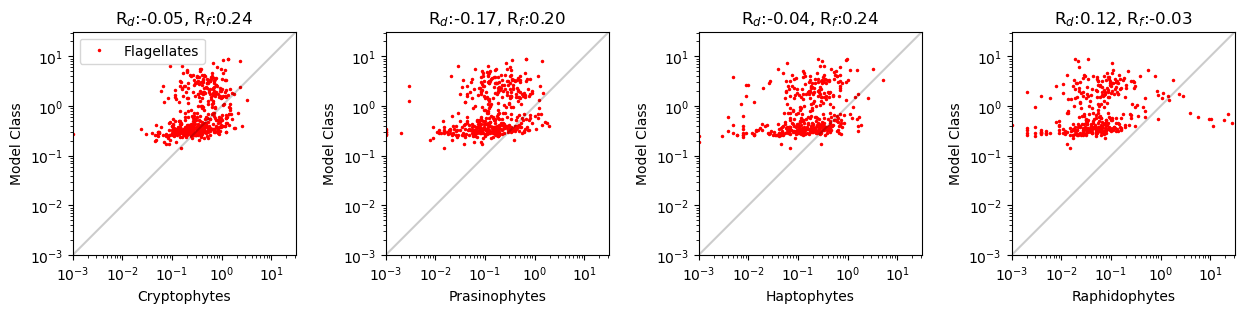

In [61]:
fig,ax=plt.subplots(1,4,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Cryptophytes', 'Prasinophytes', 
       'Haptophytes', 'Raphidophytes')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ix=~np.isnan(np.squeeze(data.loc[:,[chplc[ii]]].values))
    #ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',ms=1,color='blue',label='Diatoms')
    #ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',ms=1,color='red',label='Flagellates')
    #ax[ii].plot(data.loc[:,[chplc[ii]]].values,mvar1,'.',ms=1,color='blue',label='Diatoms')
    ax[ii].plot(data.loc[:,[chplc[ii]]].values,mvar2,'.',ms=3,color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    r1,p1=spst.pearsonr(np.squeeze(data.loc[ix,[chplc[ii]]].values),mvar1[ix])
    r2,p2=spst.pearsonr(np.squeeze(data.loc[ix,[chplc[ii]]].values),mvar2[ix])
    ax[ii].set_title(f"R$_d$:{r1:.2f}, R$_f$:{r2:.2f}")
    ax[ii].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
    ax[ii].set_xlim((10**-3,10**1.5))
    ax[ii].set_ylim((10**-3,10**1.5))
    ax[ii].set_aspect(1)
    ax[ii].set_xscale('log')
    ax[ii].set_yscale('log')
ax[0].legend()
#fig.suptitle('log10[Chl(mg/m3)+.001]');
#fig.suptitle('Chl(mg/m3)');

Text(0.001584893192461114, 10, 'r = 0.54')

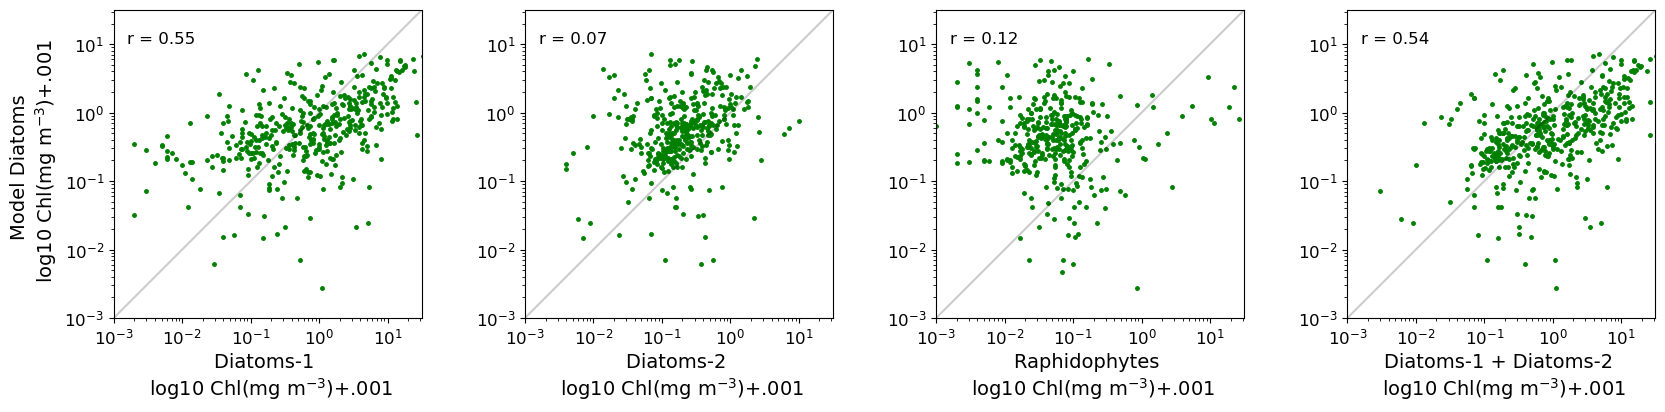

In [62]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.3)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot((data['Diatoms-1']),(data['mod_diatoms']),'g.',ms=5)
ax[0].set_ylabel('Model Diatoms \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[0].set_xlabel('Diatoms-1 \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[0].set_title('')
ax[0].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[0].set_xlim((10**-3,10**1.5))
ax[0].set_ylim((10**-3,10**1.5))
ax[0].set_aspect(1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=12)
ax[0].yaxis.set_tick_params(labelsize=12)
ax[0].text(10**-2.8,10**1, 'r = 0.55', fontsize=12,  color='k')

ax[1].plot((data['Diatoms-2']),(data['mod_diatoms']),'g.',ms=5)
ax[1].set_ylabel('')
ax[1].set_xlabel('Diatoms-2 \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[1].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[1].set_xlim((10**-3,10**1.5))
ax[1].set_ylim((10**-3,10**1.5))
ax[1].set_aspect(1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].xaxis.set_tick_params(labelsize=12)
ax[1].yaxis.set_tick_params(labelsize=12)
ax[1].text(10**-2.8,10**1, 'r = 0.07', fontsize=12,  color='k')

ax[2].plot((data['Raphidophytes']),(data['mod_diatoms']),'g.',ms=5)
ax[2].set_ylabel('')
ax[2].set_xlabel('Raphidophytes \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[2].set_title('')
ax[2].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[2].set_xlim((10**-3,10**1.5))
ax[2].set_ylim((10**-3,10**1.5))
ax[2].set_aspect(1)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].xaxis.set_tick_params(labelsize=12)
ax[2].yaxis.set_tick_params(labelsize=12)
ax[2].text(10**-2.8,10**1, 'r = 0.12', fontsize=12,  color='k')

ax[3].plot((data['Diatoms-1']+data['Diatoms-2']),(data['mod_diatoms']),'g.',ms=5)
ax[3].set_ylabel('')
ax[3].set_xlabel('Diatoms-1 + Diatoms-2 \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[3].set_title('')
ax[3].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[3].set_xlim((10**-3,10**1.5))
ax[3].set_ylim((10**-3,10**1.5))
ax[3].set_aspect(1)
ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].xaxis.set_tick_params(labelsize=12)
ax[3].yaxis.set_tick_params(labelsize=12)
ax[3].text(10**-2.8,10**1, 'r = 0.54', fontsize=12,  color='k')

Text(0.001584893192461114, 10, 'r = 0.30')

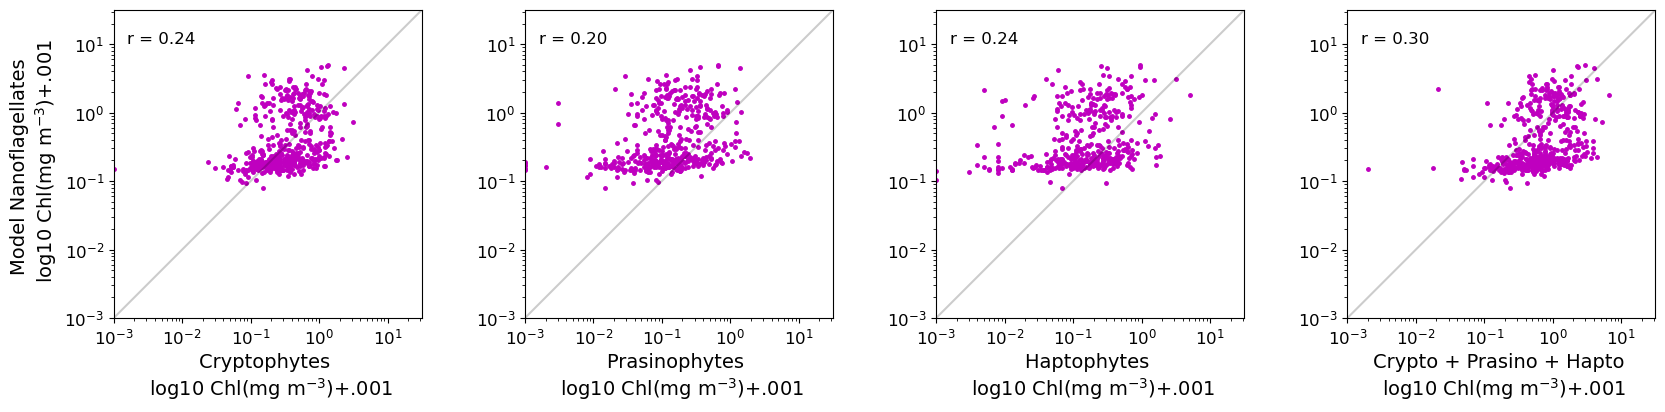

In [63]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.3)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot((data['Cryptophytes']),(data['mod_flagellates']),'m.',ms=5)
ax[0].set_ylabel('Model Nanoflagellates \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[0].set_xlabel('Cryptophytes \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[0].set_title('')
ax[0].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[0].set_xlim((10**-3,10**1.5))
ax[0].set_ylim((10**-3,10**1.5))
ax[0].set_aspect(1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=12)
ax[0].yaxis.set_tick_params(labelsize=12)
ax[0].text(10**-2.8,10**1, 'r = 0.24', fontsize=12,  color='k')

ax[1].plot((data['Prasinophytes']),(data['mod_flagellates']),'m.',ms=5)
ax[1].set_ylabel('')
ax[1].set_xlabel('Prasinophytes \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[1].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[1].set_xlim((10**-3,10**1.5))
ax[1].set_ylim((10**-3,10**1.5))
ax[1].set_aspect(1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].xaxis.set_tick_params(labelsize=12)
ax[1].yaxis.set_tick_params(labelsize=12)
ax[1].text(10**-2.8,10**1, 'r = 0.20', fontsize=12,  color='k')

ax[2].plot((data['Haptophytes']),(data['mod_flagellates']),'m.',ms=5)
ax[2].set_ylabel('')
ax[2].set_xlabel('Haptophytes \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[2].set_title('')
ax[2].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[2].set_xlim((10**-3,10**1.5))
ax[2].set_ylim((10**-3,10**1.5))
ax[2].set_aspect(1)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].xaxis.set_tick_params(labelsize=12)
ax[2].yaxis.set_tick_params(labelsize=12)
ax[2].text(10**-2.8,10**1, 'r = 0.24', fontsize=12,  color='k')

ax[3].plot((data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']),(data['mod_flagellates']),'m.',ms=5)
ax[3].set_ylabel('')
ax[3].set_xlabel('Crypto + Prasino + Hapto \n log10 Chl(mg m$^{-3}$)+.001',fontsize=14)
ax[3].set_title('')
ax[3].plot((10**-3,10**1.5),(10**-3,10**1.5),'k-',alpha=.2)
ax[3].set_xlim((10**-3,10**1.5))
ax[3].set_ylim((10**-3,10**1.5))
ax[3].set_aspect(1)
ax[3].set_xscale('log')
ax[3].set_yscale('log')
ax[3].xaxis.set_tick_params(labelsize=12)
ax[3].yaxis.set_tick_params(labelsize=12)
ax[3].text(10**-2.8,10**1, 'r = 0.30', fontsize=12,  color='k')

### Separate into grouping for which there is some model-data agreement and plot model v obs

(-3.0, 1.5)

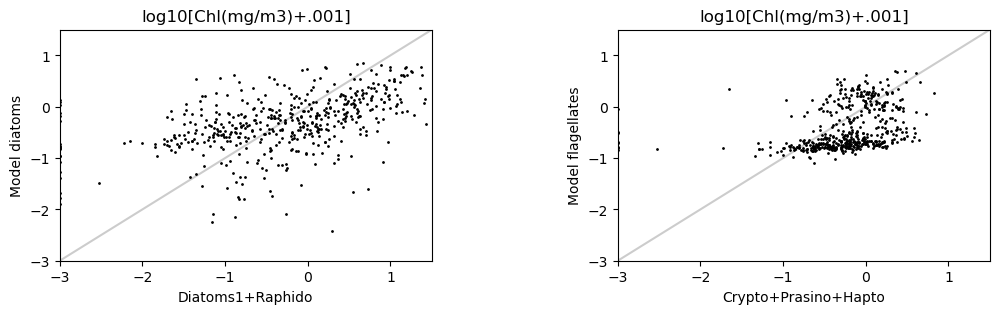

In [65]:
fig,ax=plt.subplots(1,2,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']),logt(data['mod_diatoms']),'k.',ms=2)
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']),logt(data['mod_flagellates']),'k.',ms=2)
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Crypto+Prasino+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))



### Grouped Model-Obs Comparison: 

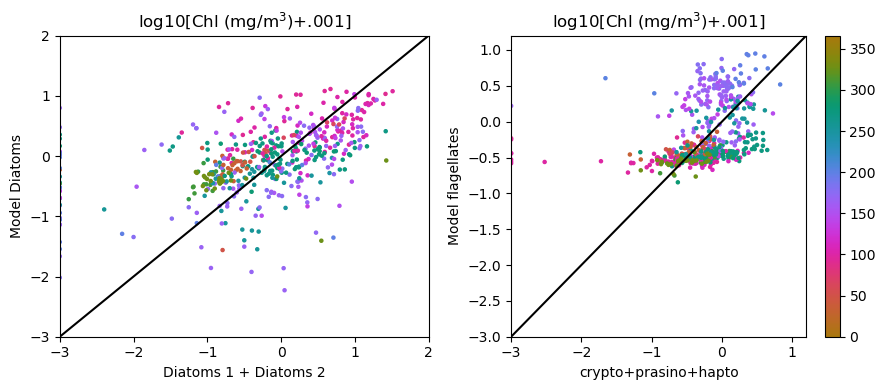

In [66]:
thresh=.8
msize=5
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CPH']),logt(data['mod_flagellates_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
# ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
# ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
# ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
# ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('New')

May-Aug


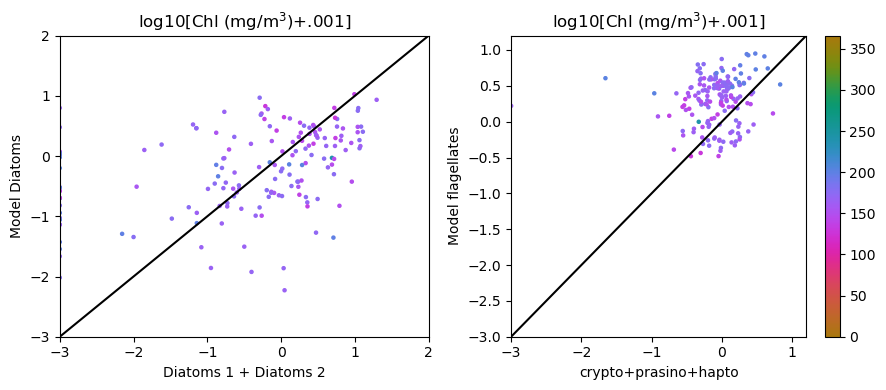

In [67]:
#thresh=.8
msize=5
data2=data.loc[(data['yd']>yd(dt.datetime(2015,5,1)))&(data['yd']<yd(dt.datetime(2015,9,1)))]
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data2['DD']),logt(data2['mod_diatoms_chl']),
          c=data2['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data2['CPH']),logt(data2['mod_flagellates_chl']),
          c=data2['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
# ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
# ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
# ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
# ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('New')
print('May-Aug')

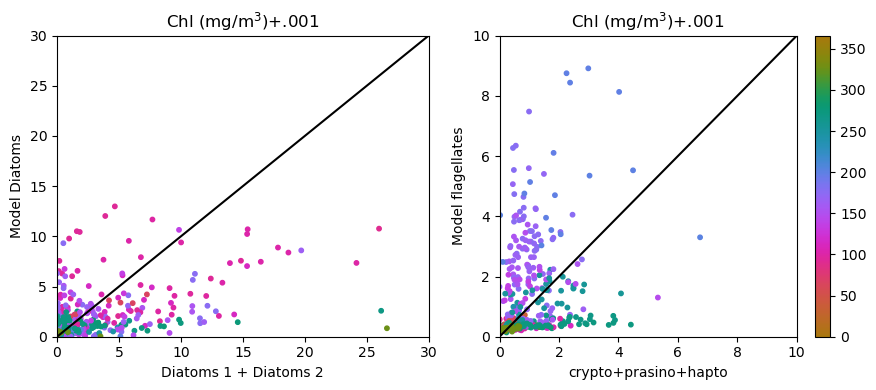

In [68]:

msize=10
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(data['DD'],data['mod_diatoms_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(data['CPH'],data['mod_flagellates_chl'],
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(0,30)
ax[0].set_ylim(0,30)
ax[1].set_xlim(0,10)
ax[1].set_ylim(0,10)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('Chl (mg/m$^3$)+.001')
ax[1].set_xlabel('crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('Chl (mg/m$^3$)+.001')
ax[0].plot((0,30),(0,30),'k-')
ax[1].plot((0,10),(0,10),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])
#fig.suptitle('new')

### Linear fits to empirical groupings
- R^2 values are low

In [69]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['DD'],
                                                              data.loc[ii]['mod_diatoms_chl'])

In [70]:
slope, intercept, r_value*r_value

(0.2859543067190371, 1.0226026657298612, 0.2968883971475856)

In [71]:
ii=(data['CPH']>=0)&(data['mod_flagellates_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(data.loc[ii]['CPH'],
                                                              data.loc[ii]['mod_flagellates_chl'])

In [72]:
slope, intercept, r_value*r_value

(0.4956020888063633, 0.7037723479735636, 0.08561349330413577)

In [73]:
ii=(data['DD']>=0)&(data['mod_diatoms_chl']>=0)
slope, intercept, r_value, p_value, std_err = spst.linregress(logt(data.loc[ii]['DD']),
                                                              logt(data.loc[ii]['mod_diatoms_chl']))

In [74]:
slope, intercept, r_value*r_value

(0.2717147500705206, 0.00890994379475029, 0.23091693574239308)

# Plot for Central SoG Region Only

In [75]:
data['LOC:STATION'].unique()

array(['SI', '59', '102', '75', '72', '69', 'ADCP', '65', '63', '62',
       '56', '46', '42', '39', 'GE01', '27', '2', '3', 'BS', '6', '9',
       '12', '14', '16', '22', '11', 'CPF2', 'CPF1', '24', '28', '38',
       '41', 'BS17', '19', 'GEO1', 'BS11', 'SC-04', '66', 'BI2', 'JF2',
       'HARO59', 'SI03', '15', 'SC04', '40', 'qu39', 'Van1', 'BS-11',
       'adcp', 'QU39', 'CPF-2', 'CPF-1', 'Haro 59', 'BS2', 'IS-2', 'PEN1',
       'PEN2', 'PEN3'], dtype=object)

In [76]:
CSOG=data.loc[(data['LOC:STATION']=='42')|(data['LOC:STATION']=='39')|(data['LOC:STATION']=='27')|(data['LOC:STATION']=='GEO1')]

### What do HPLC-based observations look like in terms of species composition?

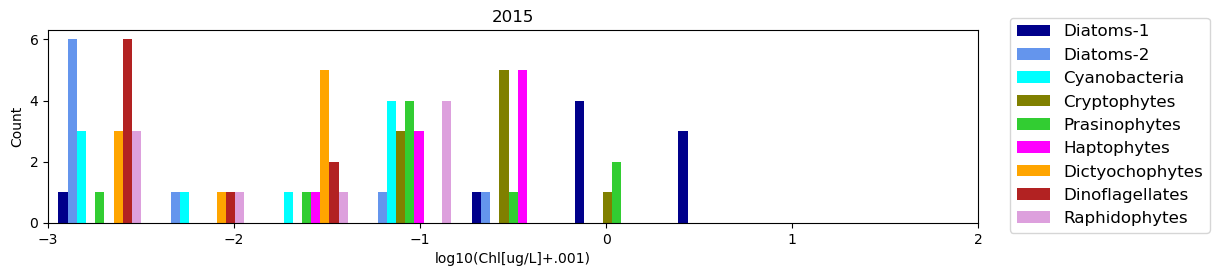

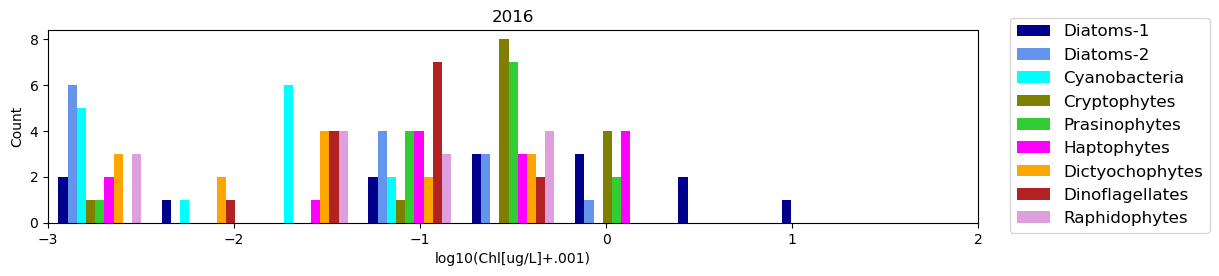

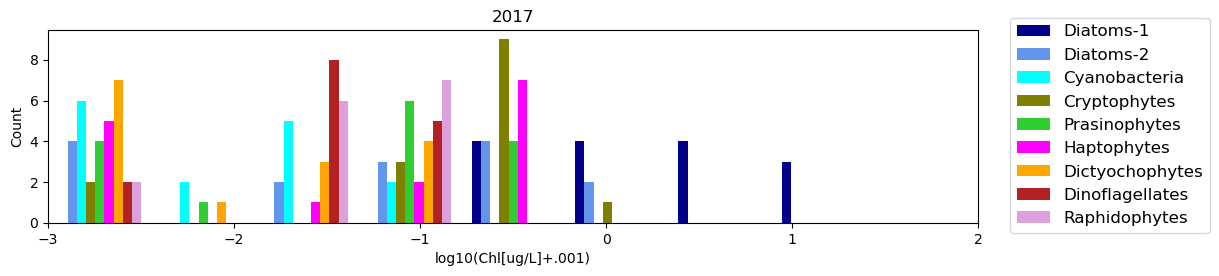

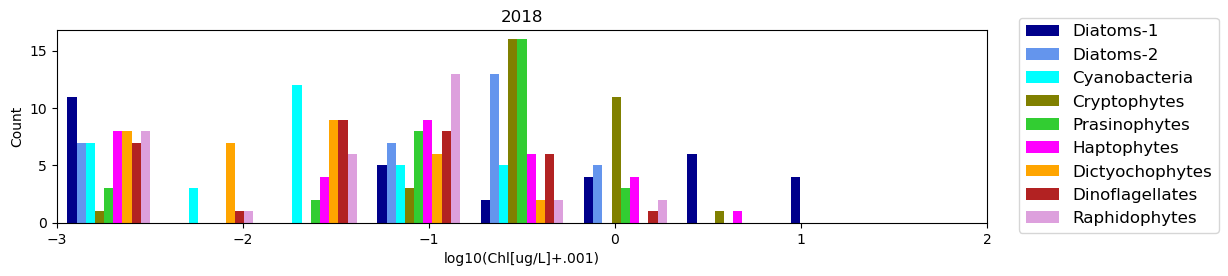

In [77]:
### Histogram by Year:
for year in range(2015,2019):
    fig,ax=plt.subplots(1,1,figsize=(12,2.5))
    hplclist=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
           'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes')
    x=np.array([logt(CSOG[CSOG.Year==year][el]) for el in hplclist]).T
    cols=('darkblue','cornflowerblue','cyan','olive','limegreen','magenta','orange','firebrick','plum')
    bins=np.linspace(-3,2,10)
    ax.hist(x, bins, density=False, histtype='bar', color=cols, label=hplclist);
    fig.legend(prop={'size': 12},loc='center right',bbox_to_anchor=[1.1,.5,0,0]);
    ax.set_xlim(-3,2)
    ax.set_xlabel('log10(Chl[ug/L]+.001)')
    ax.set_ylabel('Count')
    ax.set_title(year)

### Check that these points are true for Central SoG data only
- The most abundant groups are diatoms-1
- Medium abundance groups includ cryptophytes, prasinophytes, haptophytes, and raphidophytes, and dinoflagellates
- Low abundance groups include cyanobacteria and dictyochophytes
- The dinoflagellate contribution was higher in 2016-2018 compared to 2015.